In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")

In [2]:
df_rks = pd.read_csv('roscomsvoboda_data.csv')

In [7]:
df_rks

,appearDate,applyDate,authority,decisionDate,domains,entryType,excludeDate,id,ips,status,urls
0,2015-02-16,2014-02-17,"{'id': 2, 'name': 'Роспотребнадзор'}",2013-03-08,['religion.lilithezine.com'],1.0,NaN,10304,['198.144.150.241'],1,['http://religion.lilithezine.com/images/Suici...
1,2019-02-21,2014-04-11,"{'id': 2, 'name': 'Роспотребнадзор'}",2013-03-19,['ruckp.org'],1.0,2020-01-27,13344,"['104.18.56.37', '104.18.57.37', '2606:4700:30...",2,['http://ruckp.org/topic/9144-сценарии-для-мул...
2,2014-02-18,2014-02-18,"{'id': 2, 'name': 'Роспотребнадзор'}",2013-03-19,['lajli.gau.hu'],NaN,2018-05-10,13405,['192.188.242.125'],2,['http://lajli.gau.hu/~xx/suicide.htm?page=1']
3,2014-02-18,2014-02-18,"{'id': 2, 'name': 'Роспотребнадзор'}",2013-03-31,['forum.natali.ua'],NaN,2018-06-18,17504,['91.208.154.151'],2,['http://forum.natali.ua/viewtopic.php?t=4273']
4,2019-02-21,2014-03-03,"{'id': 1, 'name': 'ФСКН'}",2013-04-28,['www.narkop.com'],1.0,2020-01-27,27277,"['93.158.211.142', '93.158.211.129', '93.158.2...",2,['http://www.narkop.com/forum/30/']
...,...,...,...,...,...,...,...,...,...,...,...
1245862,2023-03-20,2023-03-20,"{'id': 28, 'name': 'Росалкогольрегулирование'}",2023-03-16,['11moskva.spirt-farm.site'],1.0,NaN,5599988,"['172.67.178.116', '2606:4700:3033::ac43:b274'...",1,[]
1245863,2023-03-20,2023-03-20,"{'id': 23, 'name': 'МВД'}",2020-07-15,['megamarketsb.top'],1.0,NaN,5599990,"['104.21.43.22', '172.67.216.47', '2606:4700:3...",1,[]
1245864,2023-03-20,2023-03-20,"{'id': 1355, 'name': 'Кирово-Чепецкий районный...",2023-03-14,['fe-propiska.ru'],1.0,NaN,5599991,['89.40.4.108'],1,['https://fe-propiska.ru/?ysclid=le55iilzod985...
1245865,2023-03-20,2023-03-20,"{'id': 23, 'name': 'МВД'}",2020-07-15,['gsintez.com'],1.0,NaN,5599994,"['172.67.208.45', '2606:4700:3031::ac43:d02d',...",1,[]


In [66]:
def tweak_rks(df=df_rks): 
    return (df
            # extract new features
            .assign(status=lambda df_: (df_
                                        .status
                                        .astype('string')
                                        .replace({'1':'blocked', '2':'unblocked'})),
                    authority_id=lambda df_: (df_
                                              .authority
                                              .str.extract(r"^{'id': (\d+),.+}$", expand=False)),
                    authority_name=lambda df_: (df_
                                                .authority
                                                .str.extract(r"^{'id':\s\d+,\s'name':\s'(.+)'}$", 
                                                             expand=False))
                   )
            # convert dtypes and fill missing values if needed
            .convert_dtypes()
            .assign(status=lambda df_: df_.status.astype('category'),
                    authority_id=lambda df_: df_.authority_id.astype('category'),
                    authority_name=lambda df_: df_.authority_name.astype('category'),
                    # Not very clear what the below parameter is.
                    entryType=lambda df_: (df_
                                           .entryType
                                           .fillna(99)
                                           .astype('string')
                                           .str.replace('99', 'Not Reported')
                                           .astype('category')
                                          ),
                    # convert to datetime
                    appearDate=lambda df_: pd.to_datetime(df_.appearDate, format='%Y-%m-%d', errors='coerce'),
                    applyDate=lambda df_: pd.to_datetime(df_.applyDate, format='%Y-%m-%d', errors='coerce'),
                    decisionDate=lambda df_: pd.to_datetime(df_.decisionDate, format='%Y-%m-%d', errors='coerce'),
                    excludeDate=lambda df_: pd.to_datetime(df_.excludeDate, format='%Y-%m-%d', errors='coerce')
                   )
            # Set index to record id
            .rename(columns={'id':'record_id'})
            .set_index('record_id')
            # select columns of interest
            .loc[:, ['appearDate', 'applyDate', 'authority_id', 'authority_name',
                     'decisionDate', 'domains', 'entryType', 'excludeDate', 'ips',
                     'status', 'urls']
                ]
           )
df_cleaned = tweak_rks()

Hypotheses:

Check historical patterns in blocks by different authority_names - maybe there will be patterns there?

Check Генпрокуратура first

In [100]:
def generalize_topn(ser, n=6, other='Other'):
    topn = ser.value_counts().index[:n]
    if isinstance(ser.dtype, pd.CategoricalDtype):
        ser = ser.cat.set_categories( 
            topn.set_categories(list(topn)+[other]))
    return ser.where(ser.isin(topn), other)

Заблокированные Домены                                     \
Гос. Орган                       Other Генпрокуратура     МВД Минкомсвязь   
Дата блокировки                                                             
2014-02                            NaN            2.0     NaN         NaN   
2020-01                            3.0           97.0   124.0       502.0   
2020-02                            9.0           43.0   102.0       582.0   
2020-03                            6.0            6.0    98.0       735.0   
2020-04                           16.0           24.0   111.0       694.0   
2020-05                           35.0            2.0   143.0       914.0   
2020-06                           40.0           23.0    88.0       962.0   
2020-07                           11.0           49.0    96.0      1305.0   
2020-08                           24.0          101.0   108.0      1378.0   
2020-09                           16.0          179.0   107.0      1229.0   
2020-10                           50.0           42.0   155.0      1287.0   
2020-11                           66.0           17.0   148.0      1243.0   
2020-12                           78.0           34.0   251.0      1320.0   
2021-01                           41.0           21.0   129.0       839.0   
2021-02                          109.0           63.0   129.0      1026.0   
2021-03                          196.0          104.0   172.0      1166.0   
2021-04                           96.0          140.0   200.0      1302.0   
2021-05                          114.0           84.0   216.0      1110.0   
2021-06                          110.0          118.0   216.0      1262.0   
2021-07                          267.0          368.0   135.0      1167.0   
2021-08                          265.0          217.0   281.0      1075.0   
2021-09                          388.0          524.0   208.0      1089.0   
2021-10                          401.0          438.0   233.0       812.0   
2021-11                          449.0          696.0   195.0       842.0   
2021-12                          571.0          590.0   286.0       771.0   
2022-01                          727.0          369.0   450.0       709.0   
2022-02                          638.0          410.0   328.0       959.0   
2022-03                          646.0         2219.0   351.0       745.0   
2022-04                          587.0         2143.0   520.0       924.0   
2022-05                          733.0         1598.0   589.0       786.0   
2022-06                          587.0         1813.0   721.0       823.0   
2022-07                          494.0         1895.0   549.0      1297.0   
2022-08                          713.0         2268.0   540.0      1162.0   
2022-09                          682.0         1670.0   804.0      1465.0   
2022-10                          687.0         1772.0  1710.0      1087.0   
2022-11                         2056.0          650.0  1869.0       898.0   
2022-12                         3669.0            NaN   814.0      1133.0   
2023-01                         3149.0            NaN   873.0       685.0   
2023-02                         3873.0            NaN  1335.0       899.0   
2023-03                         2420.0            NaN   996.0       666.0   

                                              
Гос. Орган      Роскомнадзор     Суд     ФНС  
Дата блокировки                               
2014-02                  NaN     NaN     NaN  
2020-01                264.0    86.0   461.0  
2020-02                165.0   330.0   388.0  
2020-03                359.0   708.0   277.0  
2020-04                345.0   884.0   174.0  
2020-05                164.0   896.0    97.0  
2020-06                212.0  1372.0     2.0  
2020-07                230.0  1242.0   191.0  
2020-08                517.0  1727.0    57.0  
2020-09                309.0  1443.0    86.0  
2020-10                230.0  1833.0   254.0  
2020-11                286.0  1151.0   847.0  

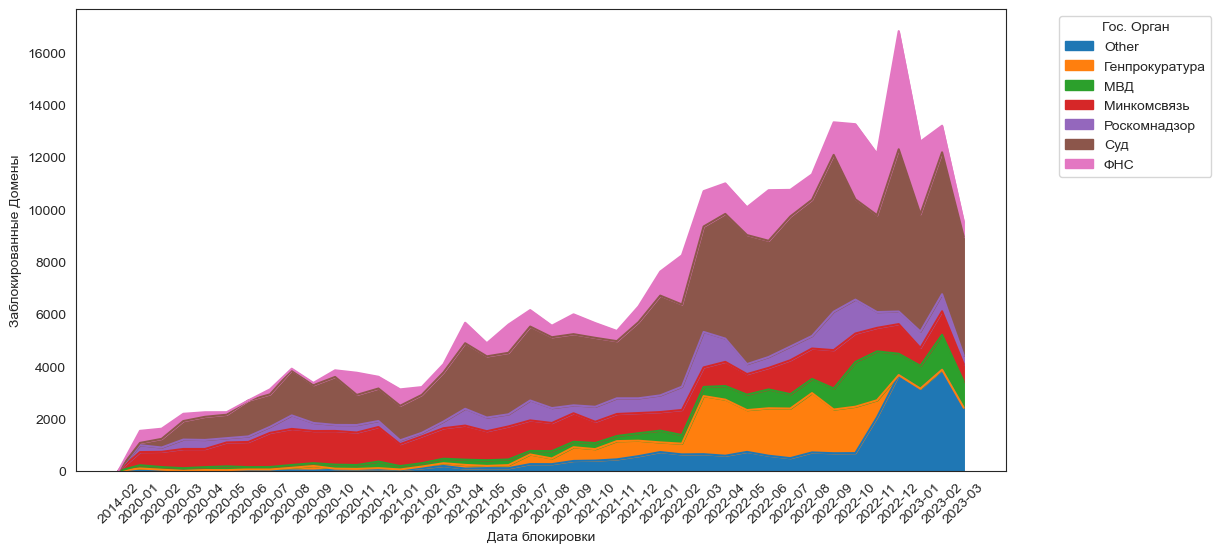

In [162]:
df_blocked_hist = (df_cleaned
                     .query("`status`=='blocked' & `decisionDate` > '2019-12-31'")
                     .assign(authority_name_red=lambda df_: (df_
                                                             .authority_name
                                                             .str.replace(r'.*[сС]уд.*', 'Суд', regex=True)
                                                             .str.replace(r'.*ОСП.*', 'Суд', regex=True)
                                                            ),
                             applyDate=lambda df_: df_.applyDate.astype('string').str[:7],
                             authority_name_red_topn=lambda df_: df_.authority_name_red.pipe(generalize_topn)
                            )
                     .groupby(['authority_name_red_topn', 'applyDate'], as_index=False)
                     .agg(domains_blocked=('domains', 'count'))
                     .loc[:, ['authority_name_red_topn', 'applyDate', 'domains_blocked']]
                     .rename(columns={
                         'authority_name_red_topn':'Гос. Орган',
                         'applyDate':'Дата блокировки',
                         'domains_blocked':'Заблокированные Домены'})
                     .sort_values(['Дата блокировки'])
                     .set_index(['Дата блокировки', 'Гос. Орган'])
                     .unstack('Гос. Орган')
                    )
# display resulting dataframe
display(df_blocked_hist)

# prepare for visualization
df_blocked_hist.columns = df_blocked_hist.columns.droplevel()
ax = df_blocked_hist.plot(kind='area', stacked=True, figsize=(12, 6))
ax.set_xticks(range(0, len(df_blocked_hist.index.get_level_values(0))))
ax.set_xticklabels(df_blocked_hist.index.get_level_values(0), rotation=45)
ax.legend(title='Гос. Орган', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_ylabel('Заблокированные Домены')
# plt.savefig('hist_data_plot.png', bbox_inches='tight')
plt.show()

In [183]:
(df_cleaned
.query("`status`=='blocked' & `decisionDate` > '2019-12-31'")
                     .assign(authority_name_red=lambda df_: (df_
                                                             .authority_name
                                                             .str.replace(r'.*[сС]уд.*', 'Суд', regex=True)
                                                             .str.replace(r'.*ОСП.*', 'Суд', regex=True)
                                                            ),
                             applyDate=lambda df_: df_.applyDate.astype('string').str[:7],
                             authority_name_red_topn=lambda df_: df_.authority_name_red.pipe(generalize_topn)
                            )
 # .query("`authority_name_red`=='Суд'")
 # .groupby('authority_name', as_index=False)
 # .agg(blocked_per_court=('domains', 'count'))
 # .query("`blocked_per_court`!=0")
 # .sort_values('blocked_per_court', ascending=False)
).to_csv('roscomsvoboda_data_blocked_2019-2023.csv', index=True)

In [181]:
(df_cleaned
.query("`status`=='blocked' & `decisionDate` > '2019-12-31'")
                     .assign(authority_name_red=lambda df_: (df_
                                                             .authority_name
                                                             .str.replace(r'.*[сС]уд.*', 'Суд', regex=True)
                                                             .str.replace(r'.*ОСП.*', 'Суд', regex=True)
                                                            ),
                             applyDate=lambda df_: df_.applyDate.astype('string').str[:7],
                             authority_name_red_topn=lambda df_: df_.authority_name_red.pipe(generalize_topn)
                            )
.query("`authority_name_red_topn`=='Other'")
.groupby('authority_name', as_index=False)
.decisionDate.count()
.query("`decisionDate`!=0")
)

,authority_name,decisionDate
429,Госорган не указан,10663
1845,Росалкогольрегулирование,3250
1846,Росздравнадзор,9878
1849,Росмолодежь,275
1850,Роспотребнадзор,940
1851,Россельхознадзор,16


In [269]:
df_region = (df_cleaned
              .assign(authority_name_red=lambda df_: (df_
                                                      .authority_name
                                                      .str.replace(r'.*[сС]уд.*', 'Суд', regex=True)
                                                      .str.replace(r'.*ОСП.*', 'Суд', regex=True)
                                                    ),
                     applyDate=lambda df_: df_.applyDate.astype('string').str[:7],
                     authority_name_red_topn=lambda df_: df_.authority_name_red.pipe(generalize_topn)
                    )
              .query("`status`=='blocked' & `decisionDate` > '2021-12-31' & `decisionDate` < '2023-01-01'")
              .query("`authority_name_red`=='Суд'")
              .assign(authority_region=lambda df_: df_.authority_name.str.extract(r'^.+- (.+)$', expand=False).fillna('')
                )
              .query("`authority_name` != 'Мосгорсуд'")
            )

df_region#.to_csv('roskomsvoboda_chelyabinsk_2021.csv')

,appearDate,applyDate,authority_id,authority_name,decisionDate,domains,entryType,excludeDate,ips,status,urls,authority_name_red,authority_name_red_topn,authority_region
record_id,,,,,,,,,,,,,,
3937585,2022-01-14,2022-01,95,Медведевский районный суд - Республика Марий Эл,2022-01-10,['odessa.myjooj.com'],1,NaT,['160.153.235.210'],blocked,['https://odessa.myjooj.com/search/hobbi-otdyh...,Суд,Суд,Республика Марий Эл
3941204,2022-01-14,2022-01,171,Ленинский районный суд г. Воронежа - Воронежск...,2022-01-10,['sex-studentki.vip'],1,NaT,"['172.67.198.227', '2606:4700:3031::ac43:c6e3'...",blocked,['http://sex-studentki.vip/rus?page=5'],Суд,Суд,Воронежская область
3941409,2022-01-14,2022-01,171,Ленинский районный суд г. Воронежа - Воронежск...,2022-01-10,['edu-diplom.com'],1,NaT,"['172.67.177.237', '2606:4700:3033::ac43:b1ed'...",blocked,[],Суд,Суд,Воронежская область
3941454,2022-01-14,2022-01,171,Ленинский районный суд г. Воронежа - Воронежск...,2022-01-10,['i-diplomsa.com'],1,NaT,['143.244.187.214'],blocked,[],Суд,Суд,Воронежская область
3941506,2022-01-14,2022-01,171,Ленинский районный суд г. Воронежа - Воронежск...,2022-01-10,['origenal-diplom.com'],1,NaT,['165.232.185.113'],blocked,[],Суд,Суд,Воронежская область
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5591791,2023-03-18,2023-03,237,Железнодорожный районный суд г. Ростова-на-Дон...,2022-12-19,['rostov.intim161.com'],1,NaT,"['172.67.134.196', '2606:4700:3037::ac43:86c4'...",blocked,[],Суд,Суд,Ростовская область
5591977,2023-03-18,2023-03,401,Октябрьский районный суд г. Ставрополя - Ставр...,2022-12-01,['russian-diplomys.com'],1,NaT,"['172.67.161.80', '2606:4700:3030::ac43:a150',...",blocked,['http://russian-diplomys.com/kupit-diplom-sta...,Суд,Суд,Ставропольский край
5592002,2023-03-20,2023-03,820,Коминтерновский районный суд г. Воронежа - Вор...,2022-12-27,['women.pimp36.com'],1,NaT,"['188.114.99.224', '188.114.98.224', '2a06:98c...",blocked,[],Суд,Суд,Воронежская область


In [227]:
stop_words = ['audio', 'video', 'sliv', 'kino', 'film', 'tv', 'movie', 'resheba', 'books', 'sex',
              'klad', 'nark', 'torrent', 'muz', 'knigi', 'hd', 'serial', 'series', 'tracker',
              'bill']

domains=['.ua']

(df_mgs
 .loc[~df_mgs.domains.str.contains("|".join(stop_words))]
 #.loc[lambda df_: df_.domains.str.contains("|".join(domains))]
)#.domains.value_counts()

,appearDate,applyDate,authority_id,authority_name,decisionDate,domains,entryType,excludeDate,ips,status,urls,authority_name_red,authority_name_red_topn
record_id,,,,,,,,,,,,,
241249,2018-08-14,2015-10,4,Мосгорсуд,2015-10-07,['uamedia.info'],2,NaT,['185.212.129.222'],blocked,['http://uamedia.info/metod-102787'],Суд,Суд
243211,2015-11-02,2015-11,4,Мосгорсуд,2015-10-07,['4fun.mksat.net'],2,NaT,['217.77.222.159'],blocked,['http://4fun.mksat.net/138056?dllist=1'],Суд,Суд
243225,2022-03-31,2015-11,4,Мосгорсуд,2015-10-07,['www.excluzive.net'],2,NaT,"['104.21.234.101', '104.21.234.100', '2606:470...",blocked,['http://www.excluzive.net/serials/1161645671-...,Суд,Суд
252814,2019-02-21,2015-12,4,Мосгорсуд,2015-10-30,['online.stepashka.com'],5,NaT,"['104.28.0.89', '104.28.1.89', '2606:4700:30::...",blocked,[],Суд,Суд
253460,2021-02-24,2015-12,4,Мосгорсуд,2015-12-10,['crdru.com'],2,NaT,"['172.67.158.219', '2606:4700:3034::ac43:9edb'...",blocked,[],Суд,Суд
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5574743,2023-03-21,2023-03,4,Мосгорсуд,2022-09-13,['ser1.ru'],2,NaT,"['172.67.220.150', '2606:4700:3033::ac43:dc96'...",blocked,"['https://ser1.ru/5563-kapelnik-2022.html', 'h...",Суд,Суд
5574767,2023-03-21,2023-03,4,Мосгорсуд,2023-02-20,['balator.info'],2,NaT,['94.124.78.122'],blocked,['https://balator.info/viewtopic.php?t=648401'],Суд,Суд
5599567,2023-03-17,2023-03,4,Мосгорсуд,2023-02-02,['ottfox.net'],5,NaT,"['104.21.62.50', '172.67.220.66', '2606:4700:3...",blocked,[],Суд,Суд


In [236]:
df_mgs.authority_name.value_counts()[:50]

Центральный районный суд г. Челябинска - Челябинская область             226
Металлургический районный суд г. Челябинска - Челябинская область        139
Советский районный суд г. Челябинска - Челябинская область               111
Калининский районный суд г. Челябинска - Челябинская область             107
Копейский городской суд - Челябинская область                             92
Еманжелинский городской суд - Челябинская область                         89
Курчатовский районный суд г. Челябинска - Челябинская область             70
Миасский городской суд - Челябинская область                              55
Увельский районный суд - Челябинская область                              54
Кыштымский городской суд - Челябинская область                            53
Правобережный районный суд г. Магнитогорска - Челябинская область         52
Агаповский районный суд - Челябинская область                             49
Снежинский городской суд - Челябинская область                            41

In [243]:
(df_cleaned
.assign(authority_name_red=lambda df_: (df_
                                      .authority_name
                                      .str.replace(r'.*[сС]уд.*', 'Суд', regex=True)
                                      .str.replace(r'.*ОСП.*', 'Суд', regex=True)
                                    ),
     applyDate=lambda df_: df_.applyDate.astype('string').str[:7],
     authority_name_red_topn=lambda df_: df_.authority_name_red.pipe(generalize_topn)
    )
.query("`status`=='blocked' & `decisionDate` > '2021-12-31' & `decisionDate` < '2023-01-01'")
).authority_name_red.value_counts()

Суд                         45760
ФНС                         21503
Генпрокуратура              16518
Минкомсвязь                 11983
Роскомнадзор                 9439
Росздравнадзор               5483
Госорган не указан           5002
МВД                          4468
Росалкогольрегулирование     2355
Роспотребнадзор               397
Росмолодежь                   150
Name: authority_name_red, dtype: int64

In [297]:
df_moscow = df_region.loc[df_region.authority_region.str.contains('Московская область', regex=True)]
df_novgorod = df_region.loc[df_region.authority_region.str.contains('Новгородская область', regex=True)]
df_tver = df_region.loc[df_region.authority_region.str.contains('Тверская область', regex=True)]
df_tula = df_region.loc[df_region.authority_region.str.contains('Тульская область', regex=True)]
df_kaluzh = df_region.loc[df_region.authority_region.str.contains('Калужская область', regex=True)]
df_vladimir = df_region.loc[df_region.authority_region.str.contains('Владимирская область', regex=True)]
df_yaroslav = df_region.loc[df_region.authority_region.str.contains('Ярославская область', regex=True)]
df_smolensk = df_region.loc[df_region.authority_region.str.contains('Смоленская область', regex=True)]
df_ryazan = df_region.loc[df_region.authority_region.str.contains('Рязанская область', regex=True)]
df_pskov = df_region.loc[df_region.authority_region.str.contains('Псковская область', regex=True)]
df_spb_obl = df_region.loc[df_region.authority_region.str.contains('Ленинградская область', regex=True)]
df_spb = df_region.loc[df_region.authority_region.str.contains('Санкт-Петербург', regex=True)]
df_msk = df_region.loc[df_region.authority_region.str.contains('Москва', regex=True)]

df_tot = pd.concat([df_moscow, df_novgorod, df_tula, df_tver, df_kaluzh, df_vladimir, df_yaroslav, df_smolensk, df_ryazan,
                   df_pskov, df_spb_obl, df_spb, df_msk])

df_tot.to_csv('roskomsvoboda_regions_of_interest_2022.csv')